In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from case3_datagen import generate_collocation_points, generate_interface_collocation_points
from case3_loss_fns import pde_loss, bc_loss, interface_loss, flexural_rigidity, normalise, denormalise
from case3_beamdoublenet import BeamDoubleNet
from case3_bayesian_opt import run_bayesian_optimisation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


/mnt/interns/csim/miniforge/envs/pinns/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total PDE points for Beam 1: 2488
Total PDE points for Beam 2: 2512


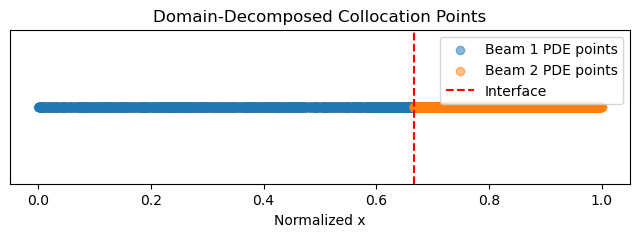

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume the following functions are defined elsewhere:
# def generate_collocation_points(n, x_ranges): ...
# def normalise(x, xmin, xmax): ...
# def generate_interface_collocation_points(n, n_interface, x_ranges, interface_x, interface_width): ...

seed=24
np.random.seed(seed)
torch.manual_seed(seed)

# --- Your Data Generation Parameters ---
n_collocation = 2000
n_interface = 1000
x_ranges = [(0,2), (2,3)]
interface_x = 2.0
interface_width = 0.1
xmin, xmax = 0.0, 3.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q0 = -500


#Generate Uniform Collocation Points for Each Domain

x1_uniform_np, x2_uniform_np = generate_collocation_points(n_collocation, x_ranges)


#Generate and Split Adaptive Collocation Points
# `generate_interface_collocation_points` is a list, and `[-1]` gets the last element.
interface_points_np = generate_interface_collocation_points(0, n_interface, x_ranges, interface_x, interface_width)[-1]

# Now, we split these points into their respective domains
interface_points_norm = normalise(interface_points_np, xmin, xmax)
interface_x_norm = normalise(interface_x, xmin, xmax)

x1_adaptive_np = interface_points_norm[interface_points_norm < interface_x_norm]
x2_adaptive_np = interface_points_norm[interface_points_norm >= interface_x_norm]


# Combine Uniform and Adaptive Points for Each Domain ---

x1_pde_combined_np = np.concatenate((normalise(x1_uniform_np, xmin, xmax), x1_adaptive_np.reshape(-1, 1)))
x2_pde_combined_np = np.concatenate((normalise(x2_uniform_np, xmin, xmax), x2_adaptive_np.reshape(-1, 1)))


# Convert to PyTorch Tensors and Finalize 
x1_pde_torch = torch.from_numpy(x1_pde_combined_np).to(torch.float32).to(device)
x2_pde_torch = torch.from_numpy(x2_pde_combined_np).to(torch.float32).to(device)

# Shuffle them to ensure they are randomly ordered (useful for minibatching)
shuffled_indices_1 = torch.randperm(len(x1_pde_torch))
x1_pde_torch = x1_pde_torch[shuffled_indices_1]

shuffled_indices_2 = torch.randperm(len(x2_pde_torch))
x2_pde_torch = x2_pde_torch[shuffled_indices_2]

# Ensure final tensors require gradients.
x1_pde_torch.requires_grad_(True)
x2_pde_torch.requires_grad_(True)

data = {
    'x1': x1_pde_torch, 
    'x2': x2_pde_torch,
    'xmin': xmin,
    'xmax': xmax,
    'device': device,
    'q0': q0,
}

print(f"Total PDE points for Beam 1: {len(x1_pde_torch)}")
print(f"Total PDE points for Beam 2: {len(x2_pde_torch)}")

# VISUALISATION
x1_pde_combined_flat = x1_pde_combined_np.flatten()
x2_pde_combined_flat = x2_pde_combined_np.flatten()
plt.figure(figsize=(8, 2))
plt.scatter(x1_pde_combined_flat, np.zeros_like(x1_pde_combined_flat), alpha=0.5, label='Beam 1 PDE points')
plt.scatter(x2_pde_combined_flat, np.zeros_like(x2_pde_combined_flat), alpha=0.5, label='Beam 2 PDE points')
plt.axvline(interface_x_norm, color='r', linestyle='--', label='Interface')
plt.xlabel('Normalized x')
plt.yticks([])
plt.title('Domain-Decomposed Collocation Points')
plt.legend()
plt.show()


In [3]:
# Bayesian search for the optimal parameters

epochs_per_trial = 200  # A small number of epochs for the search
n_trials = 100           # A reasonable number of trials
print("\n--- Starting Bayesian Optimization Search ---")
best_params = run_bayesian_optimisation(data, epochs_per_trial, n_trials, device)
print("\n--- Search Complete. Best Parameters Found ---")
print(best_params)

[I 2025-07-17 11:04:13,214] A new study created in memory with name: no-name-9020fbed-52eb-411d-8c49-ccd61e25d62f



--- Starting Bayesian Optimization Search ---


[I 2025-07-17 11:04:22,657] Trial 0 finished with value: 1114.31689453125 and parameters: {'pde_weight': 1.556836408348633, 'bc_weight': 0.024040689042556004, 'if_weight': 0.007941564696214612, 'learning_rate': 4.2414716627615835e-05}. Best is trial 0 with value: 1114.31689453125.
[I 2025-07-17 11:04:31,387] Trial 1 finished with value: 793.8403930664062 and parameters: {'pde_weight': 150.81080430348743, 'bc_weight': 7.724892409202983e-05, 'if_weight': 1.1536462594557984, 'learning_rate': 0.00010806211588230033}. Best is trial 1 with value: 793.8403930664062.
[I 2025-07-17 11:04:40,221] Trial 2 finished with value: 3119026.75 and parameters: {'pde_weight': 16.421336373669988, 'bc_weight': 1.9793187204634308, 'if_weight': 0.0028082331014399084, 'learning_rate': 2.24180982349849e-06}. Best is trial 1 with value: 793.8403930664062.
[I 2025-07-17 11:04:48,947] Trial 3 finished with value: 0.0009145366493612528 and parameters: {'pde_weight': 1.5303883281349815, 'bc_weight': 0.63463654175925

Best Trial:
 Value: 4.2761516283462697e-07
 Params: 
pde_weight: 0.0018403909743636869
bc_weight: 2.45758954425237e-06
if_weight: 4.371133234018718e-06
learning_rate: 0.0002279323016222345

--- Search Complete. Best Parameters Found ---
{'pde_weight': 0.0018403909743636869, 'bc_weight': 2.45758954425237e-06, 'if_weight': 4.371133234018718e-06, 'learning_rate': 0.0002279323016222345}


In [4]:
# Instantiate the models

n_units=40
n_layers=4
pde_weight = best_params['pde_weight']
bc_weight = best_params['bc_weight']
if_weight = best_params['if_weight']
#if_cont_weight = best_params['if_cont_weight']
#if_shear_weight = best_params['if_shear_weight']
lr = 0.0001#best_params['learning_rate']


model_beam1 = BeamDoubleNet(
    input_dim=1, output_dim=2,
    n_units=n_units, n_layers=n_layers,
    pde_weight=pde_weight, bc_weight=bc_weight, if_weight=if_weight,
    #if_cont_weight=if_cont_weight, if_shear_weight=if_shear_weight,
).to(device)

model_beam2 = BeamDoubleNet(
    input_dim=1, output_dim=2,
    n_units=n_units, n_layers=n_layers,
    pde_weight=pde_weight, bc_weight=bc_weight, if_weight=if_weight,
    #if_cont_weight=if_cont_weight, if_shear_weight=if_shear_weight,
).to(device)


# Set up the optimizer (a single optimizer to update the params of BOTH models)

optimizer = torch.optim.Adam(
    list(model_beam1.parameters()) + list(model_beam2.parameters()),
    lr=lr
)

Epoch 0: Total Loss 7.1829e+01 | PDE 6.6402e-03 | BC 3.0756e+06 | IF 1.4703e+07
Epoch 1000: Total Loss 4.5676e-07 | PDE 2.4754e-04 | BC 3.7355e-04 | IF 6.1917e-05
Epoch 2000: Total Loss 4.3949e-07 | PDE 2.3827e-04 | BC 7.1082e-05 | IF 1.8414e-04
Epoch 3000: Total Loss 4.3448e-07 | PDE 2.3553e-04 | BC 1.0119e-04 | IF 1.7752e-04
Epoch 4000: Total Loss 4.3167e-07 | PDE 2.3418e-04 | BC 9.1018e-05 | IF 1.0440e-04
Epoch 5000: Total Loss 4.3038e-07 | PDE 2.3365e-04 | BC 7.3879e-05 | IF 4.2472e-05
Epoch 6000: Total Loss 4.2989e-07 | PDE 2.3348e-04 | BC 5.8148e-05 | IF 1.2598e-05
Epoch 7000: Total Loss 4.2850e-07 | PDE 2.3274e-04 | BC 5.6001e-05 | IF 6.7614e-06
Epoch 8000: Total Loss 4.2838e-07 | PDE 2.3269e-04 | BC 5.1872e-05 | IF 2.2168e-06
Epoch 9000: Total Loss 4.2567e-07 | PDE 2.3121e-04 | BC 5.6115e-05 | IF 2.2927e-06


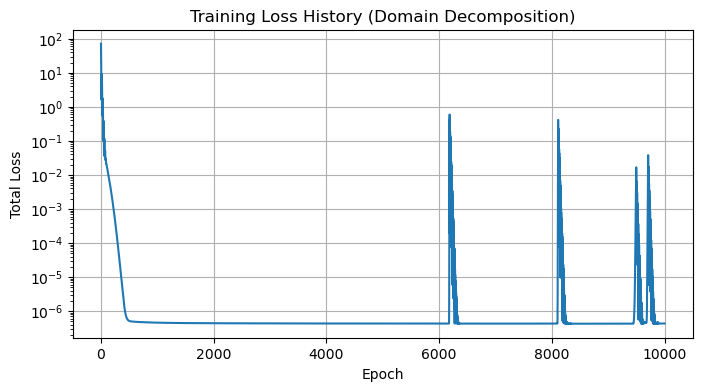

In [5]:
# training loop

losses = []
epochs=10000

for ep in range(epochs):
    # This ensures x_pde_torch has requires_grad=True, even in a notebook
    #x1_pde_torch.requires_grad_(True)
    #x2_pde_torch.requires_grad_(True)          REQUIRED WHEN MINIBATCHING
    optimizer.zero_grad()

    loss_residual = pde_loss(model_beam1, x1_pde_torch, xmin, xmax, q0) + pde_loss(model_beam2, x2_pde_torch, xmin, xmax, q0)
    loss_boundary = bc_loss(model_beam1, model_beam2, xmin, xmax)
    loss_interface = interface_loss(model_beam1, model_beam2, xmin, xmax)# if_shear_weight, if_cont_weight)

    total_loss = pde_weight*loss_residual + bc_weight*loss_boundary + if_weight * loss_interface

    #backpropagation and optimisation via pytorch
    total_loss.backward()
    optimizer.step()
    losses.append(total_loss.item())

    if ep % int(epochs/10) == 0:
        print(f"Epoch {ep}: Total Loss {total_loss.item():.4e} | "
              f"PDE {loss_residual.item():.4e} | "
              f"BC {loss_boundary.item():.4e} | "
              f"IF {loss_interface.item():.4e}")
        
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss History (Domain Decomposition)')
plt.grid(True)
plt.show()


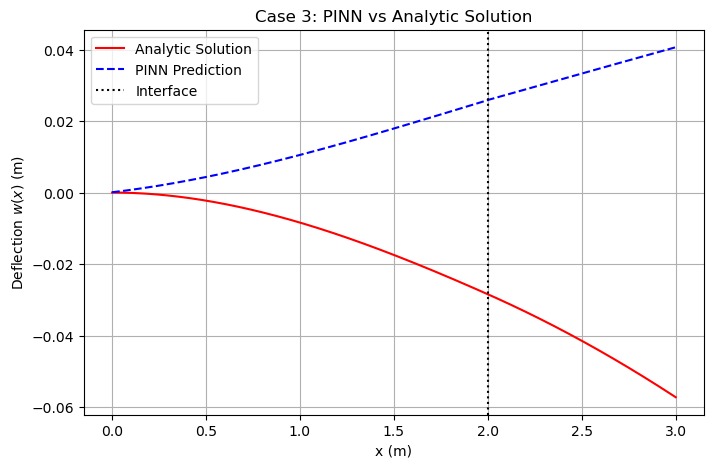

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Beam and material properties
E1, D1 = 210e9, 0.05
E2, D2 = 180e9, 0.04
I1 = np.pi/64 * D1**4
I2 = np.pi/64 * D2**4
EI1 = E1 * I1
EI2 = E2 * I2

# 2. Solve for analytic solution coefficients
A = np.zeros((5, 5))
b = np.zeros(5)

# Unknowns: [c1, d1, a2, b2, c2]
A[0, 0] = 4      # c1
A[0, 1] = 8      # d1
A[0, 2] = -1     # a2
A[0, 3] = -2     # b2
A[0, 4] = -4     # c2
b[0] = 0

A[1, 0] = 4      # c1
A[1, 1] = 12     # d1
A[1, 3] = -1     # b2
A[1, 4] = -4     # c2
b[1] = 0

A[2, 0] = 2*EI1
A[2, 1] = 12*EI1
A[2, 4] = -2*EI2
b[2] = 0

A[3, 1] = -6*EI1
b[3] = -500

A[4, 4] = 2*EI2
b[4] = -250

sol = np.linalg.solve(A, b)
c1, d1, a2, b2, c2 = sol

def w_analytic(x):
    w = np.zeros_like(x)
    mask1 = x < 2
    mask2 = x >= 2
    w[mask1] = c1 * x[mask1]**2 + d1 * x[mask1]**3
    w[mask2] = a2 + b2 * x[mask2] + c2 * x[mask2]**2
    return w

# Generate x values and normalize
x_min, x_max = 0.0, 3.0
x_phys = np.linspace(0, 3, 500)
x_norm = (x_phys - x_min) / (x_max - x_min)

# Evaluate analytic solution
w_true = w_analytic(x_phys)

x_phys = np.linspace(xmin, xmax, 500)
x_norm = normalise(x_phys, xmin, xmax)
x_norm_torch = torch.from_numpy(x_norm.reshape(-1, 1)).to(torch.float32).to(device)

# Use boolean masks to apply the correct model to each segment
interface_norm_val = normalise(interface_x, xmin, xmax)
mask1 = x_norm < interface_norm_val
mask2 = x_norm >= interface_norm_val

w_pinn = np.zeros_like(x_phys)

# Set models to evaluation mode and get predictions
model_beam1.eval()
model_beam2.eval()
with torch.no_grad():
    w_pinn[mask1] = model_beam1(x_norm_torch[mask1]).cpu().numpy()[:, 0].flatten()
    w_pinn[mask2] = model_beam2(x_norm_torch[mask2]).cpu().numpy()[:, 0].flatten()


plt.figure(figsize=(8, 5))
plt.plot(x_phys, w_analytic(x_phys), 'r-', label='Analytic Solution')
plt.plot(x_phys, w_pinn, 'b--', label='PINN Prediction')
plt.axvline(interface_x, color='k', linestyle=':', label='Interface')
plt.xlabel('x (m)')
plt.ylabel('Deflection $w(x)$ (m)')
plt.title('Case 3: PINN vs Analytic Solution')
plt.legend()
plt.grid(True)
plt.show()


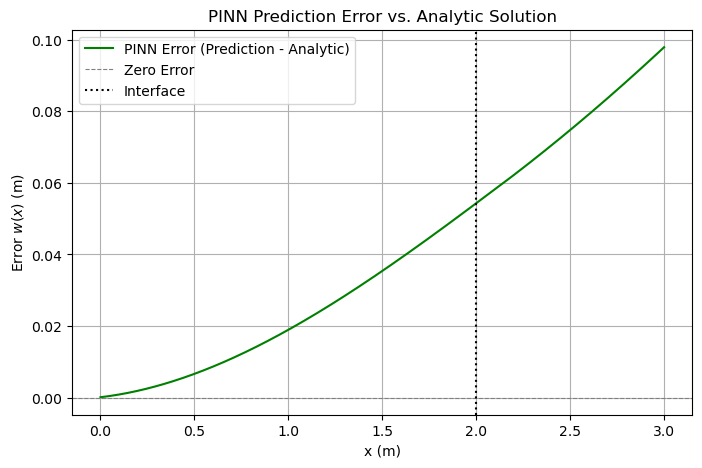

In [7]:
# error plot

error = w_pinn - w_analytic(x_phys)

# --- NEW: Plot the Error ---
plt.figure(figsize=(8, 5))
plt.plot(x_phys, error, 'g-', label='PINN Error (Prediction - Analytic)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Zero Error') # Reference line at y=0
plt.axvline(interface_x, color='k', linestyle=':', label='Interface')
plt.xlabel('x (m)')
plt.ylabel('Error $w(x)$ (m)')
plt.title('PINN Prediction Error vs. Analytic Solution')
plt.legend()
plt.grid(True)
plt.show()